##### Copyright Netherlands eScience Center <br>
** Function     : Computing AMET with Surface & TOA flux** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.09.09 ** <br>
** Last Update  : 2018.09.09 ** <br>
Description     : This notebook aims to compute AMET with TOA/surface flux fields from EC Earth model. The EC-Earth model is launched by DMI in Blue Action Work Package 3 as coordinated experiments for joint analysis. It contributes to the Deliverable 3.1. <br>
Return Values   : netCDF4 <br>
Caveat          : The fields used here are post-processed monthly mean fields. Hence there is no accumulation that need to be taken into account.<br>

Since EC-Earth is built on ECMWF IFS. The definition of variables are the same. This means for all the flux used here, downward is positive. The **positive sign** for each variable varies:<br>
* Latent heat flux (slhf) - downward (-428 to 20) <br>
* Sensible heat flux (sshf) - downward (-248 to 62) <br>
* Net solar radiation flux at TOA (tsr) - downward (0 to 448) <br>
* Net solar radiation flux at surface (ssr) - downward (0 to 363) <br>
* Net longwave radiation flux at surface (str) - downward (-175 to -2) <br>
* Net longwave radiation flux at TOA (ttr) - downward (-341 to -114) <br>


In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import scipy as sp
import time as tttt
from netCDF4 import Dataset,num2date
import os
import meta.statistics
import meta.visualizer

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [3]:
################################   Input zone  ######################################
# specify starting and ending time
start_year = 1979
end_year = 2015
# specify data path
datapath = '/home/ESLT0068/WorkFlow/Core_Database_BlueAction_WP3/ECEarth_NLeSC'
# specify output path for figures
output_path = '/home/ESLT0068/WorkFlow/Core_Database_BlueAction_WP3/AMET_netCDF'
# ensemble number
ensemble = 20
# experiment number
exp = 4
# example file
#datapath_example = os.path.join(datapath, 'slhf', 'DMI_ecearth3_BA-WP3_AEXP1-ENS1_1979-2015_2D_slhf.nc')
####################################################################################

In [16]:
name_list_run = ['5DEH']
for i in name_list_run:
    datapath_slhf = os.path.join(datapath, 'ECE_{}_SLHF_monthly_1979.nc'.format(i))
    datapath_sshf = os.path.join(datapath, 'ECE_{}_SSHF_monthly_1979.nc'.format(i))
    datapath_ssr = os.path.join(datapath, 'ECE_{}_SSR_monthly_1979.nc'.format(i))
    datapath_str = os.path.join(datapath, 'ECE_{}_STR_monthly_1979.nc'.format(i))
    datapath_tsr = os.path.join(datapath, 'ECE_{}_TSR_monthly_1979.nc'.format(i))
    datapath_ttr = os.path.join(datapath, 'ECE_{}_TTR_monthly_1979.nc'.format(i))

key_slhf = Dataset(datapath_slhf)
key_sshf = Dataset(datapath_sshf)
key_ssr = Dataset(datapath_ssr)
key_str = Dataset(datapath_str)
key_tsr = Dataset(datapath_tsr)
key_ttr = Dataset(datapath_ttr)

factor = 3600 * 3

var_slhf = key_slhf.variables['SLHF'][:] / factor # surface latent heat flux W/m2
var_sshf = key_sshf.variables['SSHF'][:] / factor # surface sensible heat flux W/m2 
var_ssr = key_ssr.variables['SSR'][:] / factor # surface solar radiation W/m2
var_str = key_str.variables['STR'][:] / factor # surface thermal radiation W/m2
var_tsr = key_tsr.variables['TSR'][:] / factor # TOA solar radiation W/m2
var_ttr = key_ttr.variables['TTR'][:] / factor # TOA thermal radiation W/m2

lat = key_ttr.variables['lat'][:]
lon = key_ttr.variables['lon'][:]

#size of the grid box
dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * lat /
                                          360) / len(lon) 
dy = np.pi * constant['R'] / len(lat)

# calculate total net energy flux at TOA/surface
net_flux_surf = var_slhf + var_sshf + var_ssr + var_str
net_flux_toa = var_tsr + var_ttr
net_flux_surf_area = np.zeros(net_flux_surf.shape, dtype=float) # unit W
net_flux_toa_area = np.zeros(net_flux_toa.shape, dtype=float)
for i in np.arange(len(lat)):
    # change the unit to terawatt
    net_flux_surf_area[:,i,:] = net_flux_surf[:,i,:]* dx[i] * dy / 1E+12
    net_flux_toa_area[:,i,:] = net_flux_toa[:,i,:]* dx[i] * dy / 1E+12

# take the zonal integral of flux
net_flux_surf_int = np.sum(net_flux_surf_area,2) / 1000 # PW
net_flux_toa_int = np.sum(net_flux_toa_area,2) / 1000
# AMET as the residual of net flux at TOA & surface
AMET_res_ERAI = np.zeros(net_flux_surf_int.shape)
for i in np.arange(len(lat)):
    AMET_res_ERAI[:,i] = -(np.sum(net_flux_toa_int[:,0:i+1],1) -
                          np.sum(net_flux_surf_int[:,0:i+1],1))

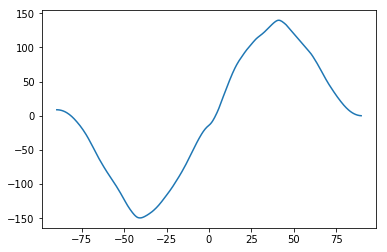

In [17]:
plt.plot(lat, np.mean(AMET_res_ERAI,0))

In [4]:
def var_key_retrieve(datapath, exp_num, ensemble_num):
    # get the path to each datasets
    print ("Start retrieving datasets of experiment {} ensemble number {}".format(exp_num+1, ensemble_num))
    # get data path
    if exp_num<2:
        if ensemble_num<10:    
            datapath_slhf = os.path.join(datapath, 'slhf', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_slhf.nc'.format(exp_num+1, ensemble_num))
            datapath_sshf = os.path.join(datapath, 'sshf', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_sshf.nc'.format(exp_num+1, ensemble_num))
            datapath_ssr = os.path.join(datapath, 'ssr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_ssr.nc'.format(exp_num+1, ensemble_num))
            datapath_str = os.path.join(datapath, 'str', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_str.nc'.format(exp_num+1, ensemble_num))
            datapath_tsr = os.path.join(datapath, 'tsr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_tsr.nc'.format(exp_num+1, ensemble_num))
            datapath_ttr = os.path.join(datapath, 'ttr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_ttr.nc'.format(exp_num+1, ensemble_num))
        else:    
            datapath_slhf = os.path.join(datapath, 'slhf', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_slhf.nc4'.format(exp_num+1, ensemble_num))
            datapath_sshf = os.path.join(datapath, 'sshf', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_sshf.nc4'.format(exp_num+1, ensemble_num))
            datapath_ssr = os.path.join(datapath, 'ssr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_ssr.nc4'.format(exp_num+1, ensemble_num))
            datapath_str = os.path.join(datapath, 'str', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_str.nc4'.format(exp_num+1, ensemble_num))
            datapath_tsr = os.path.join(datapath, 'tsr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_tsr.nc4'.format(exp_num+1, ensemble_num))
            datapath_ttr = os.path.join(datapath, 'ttr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2015_2D_ttr.nc4'.format(exp_num+1, ensemble_num))
    else:
        if ensemble_num<10:    
            datapath_slhf = os.path.join(datapath, 'slhf', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_slhf.nc'.format(exp_num+1, ensemble_num))
            datapath_sshf = os.path.join(datapath, 'sshf', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_sshf.nc'.format(exp_num+1, ensemble_num))
            datapath_ssr = os.path.join(datapath, 'ssr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_ssr.nc'.format(exp_num+1, ensemble_num))
            datapath_str = os.path.join(datapath, 'str', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_str.nc'.format(exp_num+1, ensemble_num))
            datapath_tsr = os.path.join(datapath, 'tsr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_tsr.nc'.format(exp_num+1, ensemble_num))
            datapath_ttr = os.path.join(datapath, 'ttr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_ttr.nc'.format(exp_num+1, ensemble_num))
        else:    
            datapath_slhf = os.path.join(datapath, 'slhf', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_slhf.nc4'.format(exp_num+1, ensemble_num))
            datapath_sshf = os.path.join(datapath, 'sshf', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_sshf.nc4'.format(exp_num+1, ensemble_num))
            datapath_ssr = os.path.join(datapath, 'ssr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_ssr.nc4'.format(exp_num+1, ensemble_num))
            datapath_str = os.path.join(datapath, 'str', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_str.nc4'.format(exp_num+1, ensemble_num))
            datapath_tsr = os.path.join(datapath, 'tsr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_tsr.nc4'.format(exp_num+1, ensemble_num))
            datapath_ttr = os.path.join(datapath, 'ttr', 'DMI_ecearth3_BA-WP3_AEXP{}-ENS{}_1979-2013_2D_ttr.nc4'.format(exp_num+1, ensemble_num))
    # get the variable keys            
    # get the variable keys    
    key_slhf = Dataset(datapath_slhf)
    key_sshf = Dataset(datapath_sshf)
    key_ssr = Dataset(datapath_ssr)
    key_str = Dataset(datapath_str)
    key_tsr = Dataset(datapath_tsr)
    key_ttr = Dataset(datapath_ttr)

    print ("Retrieving datasets successfully and return the variable key!")
    return key_slhf, key_sshf, key_ssr, key_str, key_tsr, key_ttr

In [5]:
def amet(key_slhf, key_sshf, key_ssr, key_str, key_tsr, key_ttr, lat, lon):
    # get all the varialbes
    # make sure that all the input variables here are positive downward!!!
    var_slhf = key_slhf.variables['slhf'][:] # surface latent heat flux W/m2
    var_sshf = key_sshf.variables['sshf'][:] # surface sensible heat flux W/m2 
    var_ssr = key_ssr.variables['ssr'][:] # surface solar radiation W/m2
    var_str = key_str.variables['str'][:] # surface thermal radiation W/m2
    var_tsr = key_tsr.variables['tsr'][:] # TOA solar radiation W/m2
    var_ttr = key_ttr.variables['ttr'][:] # TOA thermal radiation W/m2
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * lat /
                                            360) / len(lon) 
    dy = np.pi * constant['R'] / len(lat)
    # calculate total net energy flux at TOA/surface
    net_flux_surf = var_slhf + var_sshf + var_ssr + var_str
    net_flux_toa = var_tsr + var_ttr
    net_flux_surf_area = np.zeros(net_flux_surf.shape, dtype=float) # unit W
    net_flux_toa_area = np.zeros(net_flux_toa.shape, dtype=float)

    for i in np.arange(len(lat)):
        # change the unit to terawatt
        net_flux_surf_area[:,i,:] = net_flux_surf[:,i,:]* dx[i] * dy / 1E+12
        net_flux_toa_area[:,i,:] = net_flux_toa[:,i,:]* dx[i] * dy / 1E+12
    
    # take the zonal integral of flux
    net_flux_surf_int = np.sum(net_flux_surf_area,2) / 1000 # PW
    net_flux_toa_int = np.sum(net_flux_toa_area,2) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_ERAI = np.zeros(net_flux_surf_int.shape)
    for i in np.arange(len(lat)):
        AMET_res_ERAI[:,i] = -(np.sum(net_flux_toa_int[:,0:i+1],1) -
                                np.sum(net_flux_surf_int[:,0:i+1],1))
    AMET_res_ERAI = AMET_res_ERAI.reshape(-1,12,len(lat))
    return AMET_res_ERAI

In [6]:
def create_netcdf_point (pool_amet, lat, output_path, exp):
    print ('*******************************************************************')
    print ('*********************** create netcdf file*************************')
    print ('*******************************************************************')
    #logging.info("Start creating netcdf file for the 2D fields of ERAI at each grid point.")
    # get the basic dimensions
    ens, year, month, _ = pool_amet.shape
    # wrap the datasets into netcdf file
    # 'NETCDF3_CLASSIC', 'NETCDF3_64BIT', 'NETCDF4_CLASSIC', and 'NETCDF4'
    data_wrap = Dataset(os.path.join(output_path, 'amet_ECEarth_DMI_exp{}.nc'.format(exp+1)),'w',format = 'NETCDF4')
    # create dimensions for netcdf data
    ens_wrap_dim = data_wrap.createDimension('ensemble', ens)
    year_wrap_dim = data_wrap.createDimension('year', year)
    month_wrap_dim = data_wrap.createDimension('month', month)
    lat_wrap_dim = data_wrap.createDimension('latitude', len(lat))
    # create coordinate variable
    ens_wrap_var = data_wrap.createVariable('ensemble',np.int32,('ensemble',))
    year_wrap_var = data_wrap.createVariable('year',np.int32,('year',))
    month_wrap_var = data_wrap.createVariable('month',np.int32,('month',))
    lat_wrap_var = data_wrap.createVariable('latitude',np.float32,('latitude',))
    # create the actual 4d variable
    amet_wrap_var = data_wrap.createVariable('amet',np.float64,('ensemble','year','month','latitude'),zlib=True)  
    # global attributes
    data_wrap.description = 'Monthly mean atmospheric meridional energy transport'
    # variable attributes
    lat_wrap_var.units = 'degree_north'
    amet_wrap_var.units = 'PW'
    amet_wrap_var.long_name = 'atmospheric meridional energy transport'
    # writing data
    ens_wrap_var[:] = np.arange(ens)
    month_wrap_var[:] = np.arange(month)+1
    year_wrap_var[:] = np.arange(year)+1979
    lat_wrap_var[:] = lat

    amet_wrap_var[:] = pool_amet

    # close the file
    data_wrap.close()
    print ("The generation of netcdf files is complete!!")

In [ ]:
if __name__=="__main__":
    ####################################################################
    ######  Create time namelist matrix for variable extraction  #######
    ####################################################################
    # date and time arrangement
    # namelist of month and days for file manipulation
    namelist_month = ['01','02','03','04','05','06','07','08','09','10','11','12']
    # index of months
    period_1979_2015 = np.arange(start_year,end_year+1,1)
    period_1979_2013 = np.arange(start_year,end_year+1-2,1)
    index_month = np.arange(1,13,1)
    ####################################################################
    ######       Extract invariant and calculate constants       #######
    ####################################################################
    # get basic dimensions from sample file
    key_example = Dataset(datapath_example)
    lat = key_example.variables['lat'][:]
    lon = key_example.variables['lon'][:]
    # get invariant from benchmark file
    Dim_year_1979_2015 = len(period_1979_2015)
    Dim_year_1979_2013 = len(period_1979_2013)
    Dim_month = len(index_month)
    Dim_latitude = len(lat)
    Dim_longitude = len(lon)
    #############################################
    #####   Create space for stroing data   #####
    #############################################
    # data pool
    pool_amet_1979_2015 = np.zeros((ensemble,Dim_year_1979_2015,Dim_month,Dim_latitude),dtype = float)
    pool_amet_1979_2013 = np.zeros((ensemble,Dim_year_1979_2013,Dim_month,Dim_latitude),dtype = float)
    # loop for calculation
    for i in range(exp):
        for j in range(ensemble):
            # get variable keys
            key_slhf, key_sshf, key_ssr, key_str, key_tsr,\
            key_ttr = var_key_retrieve(datapath, i, j)
            # compute amet
            if i<2:
                pool_amet_1979_2015[j,:,:,:] = amet(key_slhf, key_sshf, key_ssr,
                                                    key_str, key_tsr, key_ttr, lat, lon)
            else:
                pool_amet_1979_2013[j,:,:,:] = amet(key_slhf, key_sshf, key_ssr,
                                                    key_str, key_tsr, key_ttr, lat, lon)                
        ####################################################################
        ######                 Data Wrapping (NetCDF)                #######
        ####################################################################
        # save netcdf
        if i<2:
            create_netcdf_point(pool_amet_1979_2015, lat, output_path, i)
        else:
            create_netcdf_point(pool_amet_1979_2013, lat, output_path, i)
        print ('Packing AMET is complete!!!')
        print ('The output is in sleep, safe and sound!!!')

Start retrieving datasets of experiment 1 ensemble number 0
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 1
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 2
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 3
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 4
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 5
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 6
Retrieving datasets successfully and return the variable key!
Start retrieving datasets of experiment 1 ensemble number 7
Retrieving datasets successfully and return the variable key!
Start retrieving dataset